😀模型載入與預測
==============

## 😂載入所需模組

In [56]:
import os
import time
from natsort import natsorted, ns
from PIL import Image
import numpy as np
from matplotlib.pyplot import imshow
import csv
from keras.models import load_model

## 😂定義函數

### 函數: 將資料夾內的圖片縮放成符合輸入的大小

In [57]:
def resize_images(folder):
    imgs = [os.path.join(folder, img) for img in os.listdir(folder)]
    for img in imgs:
        image = Image.open(img)
        image = image.resize((100, 50))
        image.save(img)

### 函數: 讀取資料夾內的圖片檔，並轉換成符合輸入的形式

In [1]:
def get_data(data_folder):
    img_list = os.listdir(data_folder)
    img_list = [os.path.join(data_folder, img) for img in img_list]
    img_list = natsorted(img_list, alg=ns.IGNORECASE)
    
    img_arr = []
    for img in img_list:
        image = Image.open(img)
        image = image.convert('L')
        image = np.array(image)
        img_arr.append(image.tolist())

    img_arr = np.array(img_arr)
    
    data = img_arr.reshape(img_arr.shape[0], 50, 100, 1).astype('float32')
    data /= 255
    return data

### 函數: 讀入資料標記檔，並轉換成符合輸入的形式

In [59]:
def get_labels(label_file):
    y_onehot = []
    with open(label_file) as csvfile:
        content = csv.reader(csvfile)
        for row in content:
            onehot = []
            for i, char in enumerate(row[0]):
                each_dight = [0] * 10
                each_dight[int(char)] = 1
                onehot.append(each_dight)
            y_onehot.append(onehot)

    y_Train_1 = np.array([y[0] for y in y_onehot])
    y_Train_2 = np.array([y[1] for y in y_onehot])
    y_Train_3 = np.array([y[2] for y in y_onehot])
    y_Train_4 = np.array([y[3] for y in y_onehot])
    y_Train = [y_Train_1, y_Train_2, y_Train_3, y_Train_4]
    return y_Train

### 函數: 載入資料

In [60]:
def load_data(data_folder, label_file):
    return get_data(data_folder), get_labels(label_file)

### 函數: 將預測結果轉換成對應的答案，取機率最高者

In [61]:
def pred_to_ans(x):
    pred = []
    for i in range(x[0].shape[0]):
        ans = ''
        for j in range(4):
            max_val = 0
            max_idx = 0
            for idx, val in enumerate(x[j][i]):
                if val > max_val:
                    max_val = val
                    max_idx = idx
            ans += str(max_idx)
        pred.append(ans)
    return pred

### 函數: 將資料標註轉換成對應的答案，以便與預測結果進行比較

In [62]:
def label_to_ans(y):
    answers = []
    for i in range(len(y[0])):
        ans = ''
        for j in range(4):
            for idx, val in enumerate(y[j][i]):
                if val == 1:
                    ans += str(idx)
                    break
        answers.append(ans)
    return answers

### 函數: 計算預測的準確率

In [63]:
def accuracy(pred, ans):
    num = 0
    correct_count = 0
    total = len(pred)
    wrong_list = []
    for i, j in zip(pred, ans):
        num += 1
        if i == j:
            correct_count += 1
        else:
            wrong_list.append((num ,i, j))
    return correct_count  / total, wrong_list

### 函數: 讀入資料夾內的圖片檔案，回傳成便於處理的形式

In [64]:
def load_image_arrays(data):
    img_list = os.listdir(data)
    img_list = [os.path.join(data, img) for img in img_list]
    img_list = natsorted(img_list, alg=ns.IGNORECASE)

    img_arr = []
    for img in img_list:
        image = Image.open(img)
        image = image.convert('L')
        image = np.array(image)
        img_arr.append(image.tolist())
    return img_arr

### 函數: 顯示預測錯誤的資料細節

In [65]:
import matplotlib.pyplot as plt
def plot_wrong_prediction(image_path, wrong_list):
    images = load_image_arrays(image_path)
    
    fig = plt.gcf()
    fig.set_size_inches(12, 8)
    max_num = 50
    i = 0
    for index, pred, ans in wrong_list:
        ax = plt.subplot(5, 5, 1 + i)
        ax.imshow(images[index - 1], cmap='binary')
        title = "index=" + str(index) + "\n"
        title += "label=" + ans
        title += ",predict=" + pred
        ax.set_title(title, fontsize=10)
        ax.set_xticks([])
        ax.set_yticks([])
        i += 1
        if (i >= max_num):
            break
    plt.show()

### 函數: 輸入一個串列，回傳前 **n** 大的數值在串列中的索引值

In [66]:
from heapq import nlargest

def find_n_largest_index(arr, n):
    return nlargest(n, range(len(arr)), key=lambda x: arr[x])

### 函數: 輸入一個串列，回傳陣列中相鄰數值的差

In [67]:
def find_adjacent_difference(arr):
    return [arr[i] - arr[i + 1] for i in range(len(arr) - 1)]

### 函數: 回傳前 **n** 個最有可能的答案的索引值

In [68]:
def find_n_least_difference_answer(index_list, difference_list, digit_number, n):
    pointers = [0] * digit_number
    answers_indices = [None] * n
    answers_indices[0] = [index_list[x][0] for x in range(digit_number)]
    
    for ans_count in range(1, n):
        min_diff = 1
        which_digit = 0
        for i in range(digit_number):
            if pointers[i] < n - 1 and difference_list[i][pointers[i]] <= min_diff:
                min_diff = difference_list[i][pointers[i]]
                which_digit = i
        pointers[which_digit] += 1
        g = [None] * digit_number
        for x, p in enumerate(pointers):
            g[x] = index_list[x][p]
        answers_indices[ans_count] = g
    return answers_indices

### 函數: 根據預測的機率，回傳前 **n** 個最有可能的答案

In [69]:
def get_n_most_possible_answer(the_pred, index, n):
    index -= 1
    index_list = [None] * 4
    difference_list = [None] * 4
    for i in range(4):
        index_list[i] = find_n_largest_index(the_pred[i][index], n)
        n_probs = [the_pred[i][index][k] for k in index_list[i]]
        difference_list[i] = find_adjacent_difference(n_probs)
    ans_indices = find_n_least_difference_answer(index_list, difference_list, 4, n)
    ans_list = [None] * n
    for i, each_ans in enumerate(ans_indices):
        ans_list[i] = ''.join(str(d) for d in each_ans)
    return ans_list

## 😂 載入資料及模型

### 載入訓練資料

In [70]:
training_data = 'C:\\Users\\USER\\Desktop\\Auto Bank\\hua_nan\\training_images'
training_labels = 'C:\\Users\\USER\\Desktop\\Auto Bank\\hua_nan\\training_labels.csv'
x_Train, y_Train = load_data(training_data, training_labels)
print('訓練資料:', x_Train.shape)
print('訓練標籤:', len(y_Train), '個 array')

訓練資料: (2000, 50, 100, 1)
訓練標籤: 4 個 array


### 載入測試資料

In [71]:
testing_data = 'C:\\Users\\USER\\Desktop\\Auto Bank\\hua_nan\\testing_images'
testing_labels = 'C:\\Users\\USER\\Desktop\\Auto Bank\\hua_nan\\testing_labels.csv'
x_Test, y_Test = load_data(testing_data, testing_labels)
print('測試資料:', x_Test.shape)
print('測試標籤:', len(y_Test), '個 array')

測試資料: (400, 50, 100, 1)
測試標籤: 4 個 array


### 載入完整模型與參數

In [72]:
start_time = time.time()

the_model = load_model('Models\\Captcha_Model_002.h5')

end_time = time.time()
print('花費時間:', end_time - start_time, '秒')

花費時間: 4.84925651550293 秒


### 分別載入模型及參數

In [73]:
start_time = time.time()

from keras.models import model_from_json
import json

json_string = ''
with open('Models\\Captcha_Model_002.json') as json_data:
    json_string = json.load(json_data)

the_model = model_from_json(json_string)
the_model.load_weights('Models\\Captcha_Model_Weight_002.h5')

end_time = time.time()
print('花費時間:', end_time - start_time, '秒')

花費時間: 1.151634931564331 秒


## 😂進行預測

### 將測試資料丟進模型預測

In [74]:
prediction = the_model.predict(x_Test)

### 將預測結果轉換成對應的答案，取機率最高者

In [75]:
pred = pred_to_ans(prediction)

### 將標記資料轉換成對應的答案

In [76]:
answers = label_to_ans(y_Test)

### 比較預測結果與正確答案，回傳準確率與預測錯誤的資料

In [77]:
acc, wrong = accuracy(pred, answers)

### 顯示準確率

In [78]:
print('總計', x_Test.shape[0], '筆資料')
print('準確率:', acc * 100, '%')

總計 400 筆資料
準確率: 99.75 %


### 顯示預測錯誤的圖片的細節

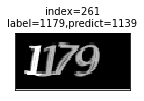

In [79]:
plot_wrong_prediction(testing_data, wrong)

### 對預測錯誤的圖片找出其他可能的答案

In [80]:
five_most_possible_answers_for_wrong_list = {}
for i, w in enumerate(wrong):
    five_most_possible_answers_for_wrong_list[w[0]] = get_n_most_possible_answer(prediction, w[0], 5)

In [81]:
for key, value in five_most_possible_answers_for_wrong_list.items():
    print('影像編號', key, '的預測前五名是', value)

影像編號 261 的預測前五名是 ['1139', '1119', '1179', '1159', '1199']
